In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [6]:
## implementar a função que identifica a bandeira
## a função deve receber uma imagem e retornar a bandeira identificada
## a função deve retornar uma lista de tuplas, onde cada tupla contém as coordenadas de um dos cantos da bandeira
## [(PAIS, (x1, y1), (x2, y2)), (PAIS, (x1, y1), (x2, y2)), (PAIS, (x1, y1), (x2, y2)), ...]

def identifica_bandeira(img):
    # Converter para HSV para facilitar detecção de cores
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Binarizar para encontrar contornos (fundo já removido, então thresh simples funciona)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    bandeiras = []
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:  # Filtro de ruído
            x, y, w, h = cv2.boundingRect(contour)
            roi = img[y:y+h, x:x+w]
            hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
            
            # Definir intervalos de cores
            red_lower1 = np.array([0, 120, 70])
            red_upper1 = np.array([10, 255, 255])
            red_lower2 = np.array([170, 120, 70])  # Segundo intervalo para vermelho
            red_upper2 = np.array([180, 255, 255])
            white_lower = np.array([0, 0, 200])
            white_upper = np.array([180, 30, 255])
            green_lower = np.array([40, 50, 50])
            green_upper = np.array([80, 255, 255])
            orange_lower = np.array([10, 100, 100])
            orange_upper = np.array([25, 255, 255])
            
            # Máscaras
            mask_red = cv2.inRange(hsv_roi, red_lower1, red_upper1) + cv2.inRange(hsv_roi, red_lower2, red_upper2)
            mask_white = cv2.inRange(hsv_roi, white_lower, white_upper)
            mask_green = cv2.inRange(hsv_roi, green_lower, green_upper)
            mask_orange = cv2.inRange(hsv_roi, orange_lower, orange_upper)
            
            # Proporções de cada cor
            total_pixels = w * h
            red_prop = cv2.countNonZero(mask_red) / total_pixels
            white_prop = cv2.countNonZero(mask_white) / total_pixels
            green_prop = cv2.countNonZero(mask_green) / total_pixels
            orange_prop = cv2.countNonZero(mask_orange) / total_pixels
            
            # Identificar o país
            pais = "desconhecido"
            
            # Mônaco: vermelho (topo), branco (baixo)
            if red_prop > 0.4 and white_prop > 0.4 and green_prop < 0.1 and orange_prop < 0.1:
                if red_prop > white_prop:  # Vermelho dominante no topo
                    pais = "monaco"
            
            # Peru: vermelho, branco, vermelho
            elif red_prop > 0.6 and white_prop > 0.2 and green_prop < 0.1 and orange_prop < 0.1:
                pais = "peru"
            
            # Singapura: vermelho (topo), branco (baixo) - simplificado
            elif red_prop > 0.3 and white_prop > 0.3 and green_prop < 0.1 and orange_prop < 0.1:
                if red_prop < 0.6:  # Diferenciar de Mônaco
                    pais = "singapura"
            
            # Irlanda: verde, branco, laranja
            elif green_prop > 0.2 and white_prop > 0.2 and orange_prop > 0.2 and red_prop < 0.1:
                pais = "irlanda"
            
            # Itália: verde, branco, vermelho
            elif green_prop > 0.2 and white_prop > 0.2 and red_prop > 0.2 and orange_prop < 0.1:
                pais = "italia"
            
            # Adicionar à lista no formato exigido
            bandeiras.append((pais, (x, y), (x + w, y + h)))
    
    return bandeiras

In [7]:
## nao alterar essa função
# Função para desenhar as bandeiras identificadas
def draw_bandeiras(lista_bandeiras, bgr):
    try:
        for bandeira in lista_bandeiras:
            cv2.rectangle(bgr, bandeira[1], bandeira[2], (255, 0, 0), 5)
            cv2.putText(bgr, bandeira[0], bandeira[1], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        return bgr
    except Exception as e:
        return bgr

Resultado para img/teste1.png: [('desconhecido', (192, 496), (457, 674)), ('desconhecido', (726, 163), (984, 370)), ('peru', (118, 121), (381, 296))]


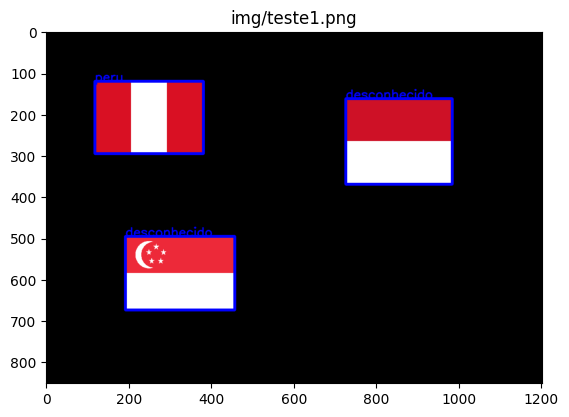

Resultado para img/teste2.png: [('irlanda', (705, 589), (971, 723)), ('italia', (343, 298), (608, 475))]


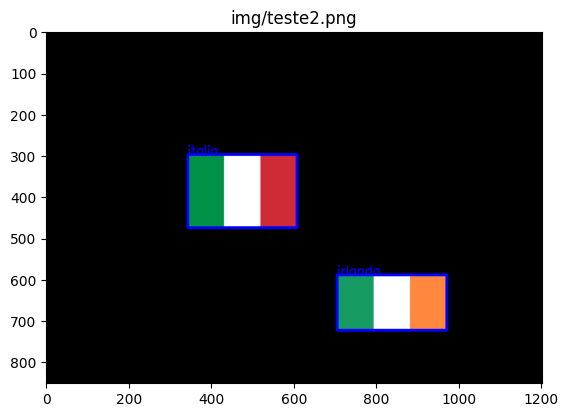

Resultado para img/teste3.png: [('peru', (751, 445), (1013, 620)), ('desconhecido', (125, 261), (391, 438))]


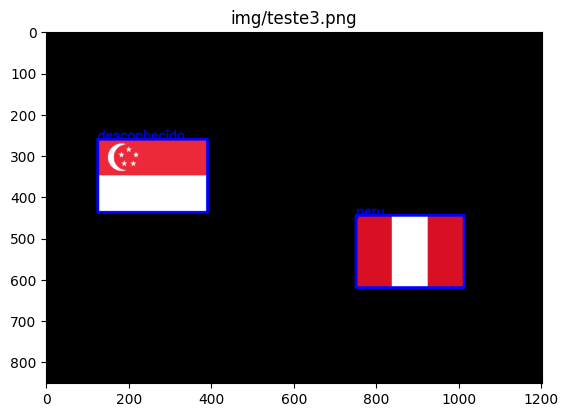

Resultado para img/teste4.png: [('peru', (767, 496), (1030, 672)), ('italia', (84, 477), (349, 654)), ('irlanda', (752, 114), (1018, 247))]


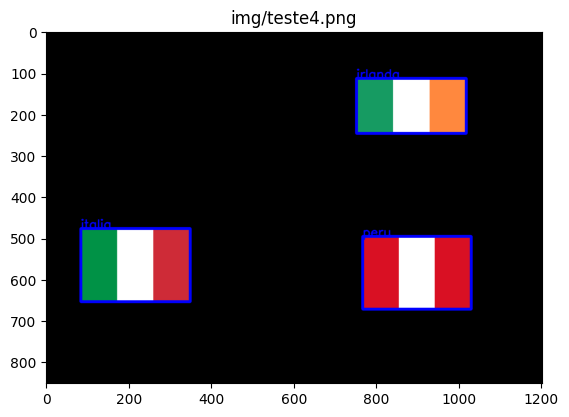

In [8]:
## Para testar a função identifica_bandeira

# Testar com todas as imagens de teste fornecidas
imagens_teste = ['img/teste1.png', 'img/teste2.png', 'img/teste3.png', 'img/teste4.png']

for img_path in imagens_teste:
    # Carregar a imagem
    img = cv2.imread(img_path)
    if img is None:
        print(f"Erro ao carregar {img_path}")
        continue
    
    # Chamar a função identifica_bandeira
    resultado = identifica_bandeira(img)
    
    # Imprimir o resultado
    print(f"Resultado para {img_path}: {resultado}")
    
    # Desenhar as bandeiras na imagem
    bgr = draw_bandeiras(resultado, img)
    plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    plt.title(img_path)
    plt.show()